http://www.adeveloperdiary.com/data-science/machine-learning/derivation-and-implementation-of-baum-welch-algorithm-for-hidden-markov-model/

Baum-Welch does only find local optima.
Insufficient training data can cause parameter estimations to vary wildly.

In [1]:
%pylab inline
plt.style.use('./BG.mplstyle')
%config InlineBackend.figure_format = 'retina'

import pickle
import pandas as pd

import numpy as np
np.seterr(divide='ignore', invalid='ignore')

Duplicate key in file './BG.mplstyle', line 21 ('patch.linewidth: 0.5')
Duplicate key in file './BG.mplstyle', line 34 ('grid.linestyle: -    # solid line')


Populating the interactive namespace from numpy and matplotlib


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
a_file = open("./src/generated_files/input_hmm.pkl", "rb")
input_hmm = pickle.load(a_file)

unigram = input_hmm.get('unigram')
uni = input_hmm.get('uni')

df = pd.read_csv('./data_TM2/processed/processed_utterances_sentence_DA_labeling.csv', index_col=0)

In [3]:
def obs_as_int(uni, unigram):
    '''returns unique list with all observations encoded into numbers.
    observation encodings are in the same order as the array weights used as input to the emission prob'''
    
    unique_DA = list(uni.keys())
    da_to_int = {}

    for i in unique_DA:
        da_to_int[i] = unique_DA.index(i)

    obs_as_integ = []

    for obs in unigram:
        observation_as_int = []
        for da in obs:
            for k in da_to_int.keys():
                if da == k:
                    da = da_to_int.get(k)
            observation_as_int.append(da) 
        obs_as_integ.append(observation_as_int)
            
    return obs_as_integ, unique_DA

In [4]:
def forward(V, a, b, initial_distribution): # V=observations, a=trans_p, b=emis_p, initial_dist=pi 
    α = np.zeros((V.shape[0], a.shape[0])) #shape (n_rows_in_excel * n_hidden_states) Here (500,2) .n_examples (not sure if each is an observation, each is one line of the excel)
    α[0, :] = initial_distribution * b[:, V[0]] # apply initial distribution * emission prob on (row 0, and all 2 columns)

    for t in range(1, V.shape[0]): # n_examples of csv 500
        for j in range(a.shape[0]): # n_hidden_states 2
            α[t, j] = α[t - 1].dot(a[:, j]) * b[j, V[t]]
            #α[example, state] = α[prev_example] * trans_p for that state * emis_p for that state, for that obs
 
    return α
 
def backward(V, a, b):
    β = np.zeros((V.shape[0], a.shape[0]))
 
    # setting β(T) = 1
    β[V.shape[0] - 1] = np.ones((a.shape[0]))
 
    # Loop in backward way from T-1 to
    # Due to python indexing the actual loop will be T-2 to 0
    for t in range(V.shape[0] - 2, -1, -1):
        for j in range(a.shape[0]):
            β[t, j] = (β[t + 1] * b[:, V[t + 1]]).dot(a[j, :])
 
    return β
 
def baum_welch(V, a, b, initial_distribution, n_iter=100):
    M = a.shape[0] # maximization step. shape n_hidden_states >>>> Here 2
    T = len(V) # len of observations >>> Here 635219
 
    for n in range(n_iter): #for each epoch
        α = forward(V, a, b, initial_distribution)
        β = backward(V, a, b)
 
        xi = np.zeros((M, M, T - 1)) #here (2 x 2 x 500)>(n_hid, n_hid, n_observ)
        for t in range(T - 1): #for all obs except last (since you need to use future time stamp)
            denominator = np.dot(np.dot(α[t, :].T, a) * b[:, V[t + 1]].T, β[t + 1, :])
            for i in range(M):
                numerator = α[t, i] * a[i, :] * b[:, V[t + 1]].T * β[t + 1, :].T
                xi[i, :, t] = numerator / denominator
 
        γ = np.sum(xi, axis=1)
        a_n = np.sum(xi, 2) 
        a_d = np.sum(γ, axis=1).reshape((-1, 1))
        a = a_n/a_d
        # a = np.sum(xi, 2) / np.sum(γ, axis=1).reshape((-1, 1))
 
        # Add additional T'th element in γ
        γ = np.hstack((γ, np.sum(xi[:, :, T - 2], axis=0).reshape((-1, 1))))
 
        K = b.shape[1] #n_of_unique_visible_states. Here 3, in my case n of unique DAs. used to calculate emission of visible state (DA_0 to DA_n) given a hidden state
        # denominator = np.sum(γ, axis=1)
        b_d = np.sum(γ, axis=1)
        for l in range(K):
            b[:, l] = np.sum(γ[:, V == l], axis=1) #sum all row values from γ only from column of that DA
        b_n = b
        # b = np.divide(b, denominator.reshape((-1, 1)))
        b = np.divide(b, b_d.reshape((-1, 1)))
 
    return {"a":a, "b":b, 'a_n':a_n, 'a_d':a_d, 'b_n':b_n, 'b_d':b_d}


In [5]:
def input_in_vit_BW_results(a,b,initial_p,unique_DA):
    
    states = ['New', 'Current']
    start_p = {'New':initial_p[0],'Current':initial_p[1]}
    trans_p = {'New': {'New':a[0][0],'Current':a[0][1]}, 'Current': {'New': a[1][0],'Current':a[1][1]}} #the higher current, more it appears. 0.6 too litle, 0.7 too much
    emis_p = {}
    b_new = {}
    for da, be in zip(unique_DA, b[0]):
        b_new[da] = be
        
    b_cur = {}
    for da, be in zip(unique_DA, b[1]):
        b_cur[da] = be
    
    emis_p['New'] = b_new
    emis_p['Current'] = b_cur
    
    return states, start_p, trans_p, emis_p


In [6]:
#viterbi working version explained from my notebook Cluster_and_HMM_first_approach

def viterbi(obs, states, start_p, trans_p, emit_p):
    V = [{}]
    for st in states:
        V[0] [st] = {"prob": start_p[st] * emit_p[st] [obs[0]], "prev": None} 
        
    # Run Viterbi when t > 0
    for t in range(1, len(obs)):
        V.append({})
        for st in states:
            max_tr_prob = V[t - 1] [states[0]] ["prob"] * trans_p[states[0]] [st] #0.026402178674778336*0.1 and same*0.9
            prev_st_selected = states[0]
            
            for prev_st in states[1:]:
                tr_prob = V[t - 1] [prev_st] ["prob"] * trans_p[prev_st] [st] # a diferenca aqui em relacao ao max_tr_prob é que aqui se calcula o previous state
                if tr_prob > max_tr_prob: #if other state is higher than state 0 (i.e if Current > New)
                    max_tr_prob = tr_prob #then new max is Current instead on New. Here we store the actual probability
                    prev_st_selected = prev_st #and previous state is updated. Here we store name of state

            max_prob = max_tr_prob * emit_p[st] [obs[t]] #prob of state* emission prob of the DA being observed
            V[t] [st] = {"prob": max_prob, "prev": prev_st_selected}


#     for line in dptable(V):
#         print(line)

    optimal = []
    max_prob = 0.0
    best_st = None
    
    # Get most probable state and its backtrack
    for st, data in V[-1].items(): #V[-1] is the last dic. ex: {'New': {'prob': 6.983898154776834e-19, 'prev': 'Current'}, 'Current': {'prob': 1.5713770848247866e-18, 'prev': 'New'}
        if data["prob"] > max_prob: #6.983898154776834e-19 > 0.0 (in first step)
            max_prob = data["prob"] #update max prob to compare with second state in next iteration
            best_st = st
    optimal.append(best_st) #appending all best states
    previous = best_st #updating previous as best state to be used later


    # Follow the backtrack till the first observation
    for t in range(len(V) - 2, -1, -1): # start=len(V)-2, stop=-1, step=-1. Calculates from last step to first
        optimal.insert(0, V[t + 1] [previous] ["prev"])
        previous = V[t + 1] [previous] ["prev"]

#     print ("The steps of states are " + " ".join(optimal) + " with highest probability of %s" % max_prob)
    return optimal, max_prob

def dptable(V):
    # Print a table of steps from dictionary
    yield " " * 5 + "     ".join(("%3d" % i) for i in range(len(V)))
    for state in V[0]:
        yield "%.7s: " % state + " ".join("%.7s" % ("%lf" % v[state] ["prob"]) for v in V)

In [12]:
def all_dialogues_hmm(unigram, uni):
    
    obs_as_integ, unique_DA = obs_as_int(uni, unigram)
    hmm_seq = []
    failed_indexes = []

    a_nominator = []
    a_denominator = []
    b_nominator = []
    b_denominator = []
    bw_ind = []

    for inte in obs_as_integ:

        V = np.array(inte) #testing with 2 observations

        # Transition Probabilities >>>>>> shape (N_hidden_states * N_hidden_states)
        a = np.array(((0.1, 0.9), (0.4,0.6))) #if I want to input my own perception as initial state. each row (hidden state) sum to 1
#         a = np.ones((2, 2))
#         a = a / np.sum(a, axis=1)
        
        # Emission Probabilities >>>>>> # shape (rows = N_hidden_states, columns = N_DAs). (prob of given a state observing a specific DA)
        b = np.array((list(uni.values()), list(uni.values()))) #using unigram probabilities. each row (hidden state) sum to 1  

        # Probabilities for the initial distribution
        initial_distribution = np.array((0.9999, 0.0001))

        bw = baum_welch(V, a, b, initial_distribution, n_iter=10)

        a_nominator.append(bw.get('a_n'))
        a_denominator.append(bw.get('a_d'))
        b_nominator.append(bw.get('b_n'))
        b_denominator.append(bw.get('b_d'))
        bw_ind.append(bw)

    a_total = np.sum(np.array(a_nominator),axis=0)/np.sum(np.array(a_denominator),axis=0)
    b_total = sum([np.divide(b_nom, b_den.reshape((-1, 1))) for b_nom,b_den in zip(b_nominator,b_denominator)],axis=0)
    
    states, start_p, trans_p, emis_p = input_in_vit_BW_results(a_total,b_total, initial_distribution, unique_DA)
    print(trans_p)
    print(emis_p)
    
    for e, dialog in enumerate(unigram):
        try:
            seq, p = viterbi(dialog, states, start_p, trans_p, emis_p)
            hmm_seq.append([dialog[2:-2], seq[2:-2], p]) #remove extra symbols from dialog (<s>, <ss>, <e>, <ee>)
        except Exception:
            failed_indexes.append(e)
            pass

    return hmm_seq, failed_indexes


In [13]:
model_name = 'HMM'

unique_ids = input_hmm.get('unique_ids') # same as input_hmm['unique_ids']

hmm_seq, failed_indexes = all_dialogues_hmm(unigram, uni)
print('Count of dialogues that failed and went to exception: ' + str(len(failed_indexes)))

### Manual Inspection
# i = 0

# #sanity check first
# print(len(hmm_seq[i][0]) == len(hmm_seq[i][1]) == len(df['new_text'].loc[df['conversation_id'] == unique_ids[i]]))
# print(len(hmm_seq[i][0]))
# print(len(hmm_seq[i][1]))
# print(len(df['new_text'].loc[df['conversation_id'] == unique_ids[i]]))

# ################## THE TEST INSPECTION IS NOT MATCHING RN. TAKING TEXT FROM OTHER DIALOGUES 

# teste_inspection = pd.DataFrame(list(zip(hmm_seq[i][0], hmm_seq[i][1], df['new_text'].loc[df['conversation_id'] == unique_ids[i]])),columns =['DA', 'HMM', 'Text'])
# teste_inspection

{'New': {'New': 0.020466984892135696, 'Current': 0.979533015107857}, 'Current': {'New': 0.39065093065972767, 'Current': 0.6093490693402687}}
{'New': {'<UNK>': 2080.191218228411, 'A_detail_request': 1223.1175888264067, 'U_answer': 1337.8698127482655, 'A_greeting': 2259.8731661806264, 'U_confirmation': 1163.7314856713547, 'A_confirmation': 965.7075715907291, 'U_partial_request': 1052.2831544216574, 'A_grant': 942.5516344302081, 'U_greeting': 1634.7206071615155, 'U_sequence_closer': 849.206366616564, 'A_sequence_closer': 522.5788083302621, '<ee>': 691.6707829061811, '<e>': 273.451643058006, '<ss>': 2.818158068227409e-06, '<s>': 1785.633369705174, 'A_completion_check': 137.1945974593654, 'A_hold_request': 147.8834791639793, 'A_receipt': 117.84182126789946, 'A_repair_initiator': 38.64307967214716, 'A_disconfirmation': 28.02812755077638, 'U_disconfirmation': 16.280857463574787, 'U_repair_initiator': 12.704240410514096, 'U_receipt': 3.3716676742212903, 'U_completion_check': 2.527119386047418,

/var/folders/3s/9v17gzrj1kvctdbg2vd9d2qw0000gn/T/ipykernel_20790/4044480997.py:21: RuntimeWarning: overflow encountered in double_scalars
  max_prob = max_tr_prob * emit_p[st] [obs[t]] #prob of state* emission prob of the DA being observed


Count of dialogues that failed and went to exception: 0


In [14]:
def plot_literal_count_per_seq(seq_sizes, model_name):
    names = list(seq_sizes.keys())
    values = list(seq_sizes.values())

    plt.bar(range(len(seq_sizes)), values, tick_label=names)
    plt.savefig('./src/generated_files/plot_literal_count_per_seq_'+ model_name + '.png')
    plt.show()

    # return plt.bar(range(len(seq_sizes)), values, tick_label=names)

def plot_grouped_per_len_seq(sorted_d, seq_to_plot, model_name):
    
    #isso seria pra plotear todos os elementos do dict
    sorted_names = list(sorted_d.keys())
    sorted_values = list(sorted_d.values())
    sorted_len_each_seq = []

    for s in seq_to_plot:
    #     print(len(s), s)
        sorted_len_each_seq.append(len(s))

    df_plot = pd.DataFrame(list(zip(sorted_names, sorted_values, sorted_len_each_seq)),columns =['Name', 'values', 'seq_len'])

    df_plot.drop(0, axis=0, inplace=True)
    df_plot.head(10)

    print('sequence sizes in different ranges of sequence count:')
    print('number of sequences with more than 1000 counts and their length: ')
    print(df_plot['seq_len'].loc[df_plot['values'] > 1000].value_counts())
    print('number of sequences between 500 and 1000 counts and their length: ')
    print(df_plot['seq_len'].loc[(df_plot['values'] > 500) & (df_plot['values'] < 1000)].value_counts())
    print('number of sequences with less than 500 counts and their length: ')
    print(df_plot['seq_len'].loc[df_plot['values'] < 500].value_counts())

    print(df_plot['seq_len'].max())
    print(df_plot['seq_len'].min())
    print('mean len: '+ str(df_plot['seq_len'].mean()))
    
    fig, ax = plt.subplots()
    df_plot.hist('seq_len', ax=ax)
    fig.savefig('./src/generated_files/hist_'+ model_name + '.png')
    
def sorted_seq_and_counts_hmm(hmm_seq):

    all_da_seq = []
    all_hid_seq = []
    count = 0

    for e, i_ in enumerate(hmm_seq):
        s_da = hmm_seq[e][0]
        s_hid = hmm_seq[e][1]
        
        if len(s_da)==len(s_hid): #sanity check that all contain same len
            #https://thispointer.com/python-how-to-find-all-indexes-of-an-item-in-a-list/
            index_new = list(locate(s_hid, lambda a: a == 'New')) 
            #https://www.geeksforgeeks.org/python-custom-list-split/?ref=lbp 
            split_hidden_lab = [s_hid[i : j] for i, j in zip([0] +  index_new, index_new + [None])]
            split_da_lab = [s_da[i : j] for i, j in zip([0] +  index_new, index_new + [None])]

            all_hid_seq.append(split_hidden_lab)
            all_da_seq.append(split_da_lab)
        else: count+=1

    sorted_d = count_and_order_seq(all_da_seq)

    seq_to_plot = []

    for key, value in sorted_d.items():
        seq_to_plot.append(key.split(' '))
        
    max_len = len(max(seq_to_plot, key=len))
    min_len = len(min(seq_to_plot, key=len))

    seq_sizes = {}

    for seq in seq_to_plot:
        for leng in range(max_len):
            if len(seq) == leng:
                seq_sizes[leng] = seq_sizes[leng] + sorted_d.get(' '.join(seq)) if leng in seq_sizes else sorted_d.get(' '.join(seq))

    # seq_sizes = sorted(seq_sizes.items(), key=operator.itemgetter(1),reverse=True)

    print('minimum len: '+ str(min_len))
    print('maximum len: '+ str(max_len))
    print('counts of number of sequences of each len (ranking): ' + str(seq_sizes))   #(sorted(seq_sizes.items(), key=operator.itemgetter(1),reverse=True)))

    return sorted_d, seq_sizes, seq_to_plot


### AUX FUNCT
def count_and_order_seq(all_da_seq):

    # print(all_da_seq)
    seq_counts = {}

    for seq in all_da_seq:
        for sub_seq in seq:
            sub_seq = ' '.join(sub_seq)
            seq_counts[sub_seq] = seq_counts[sub_seq] + 1 if sub_seq in seq_counts else 1
            
    sorted_d = dict(sorted(seq_counts.items(), key=operator.itemgetter(1),reverse=True))
    return sorted_d

minimum len: 1
maximum len: 74
counts of number of sequences of each len (ranking): {1: 15928, 2: 21245, 3: 11527, 4: 8373, 5: 6744, 6: 5719, 7: 4997, 8: 4275, 9: 3458, 10: 3023, 11: 2361, 12: 2001, 15: 1154, 13: 1618, 16: 968, 14: 1368, 35: 49, 21: 458, 26: 204, 20: 507, 19: 560, 28: 140, 17: 816, 22: 345, 25: 246, 30: 110, 29: 115, 24: 276, 27: 174, 32: 76, 48: 14, 38: 36, 31: 92, 47: 7, 58: 2, 18: 693, 33: 70, 23: 314, 36: 36, 34: 55, 43: 7, 46: 11, 39: 22, 37: 39, 56: 2, 41: 13, 54: 3, 52: 5, 40: 25, 45: 9, 53: 2, 55: 4, 42: 8, 44: 16, 51: 2, 49: 6, 60: 1, 50: 3, 57: 1}


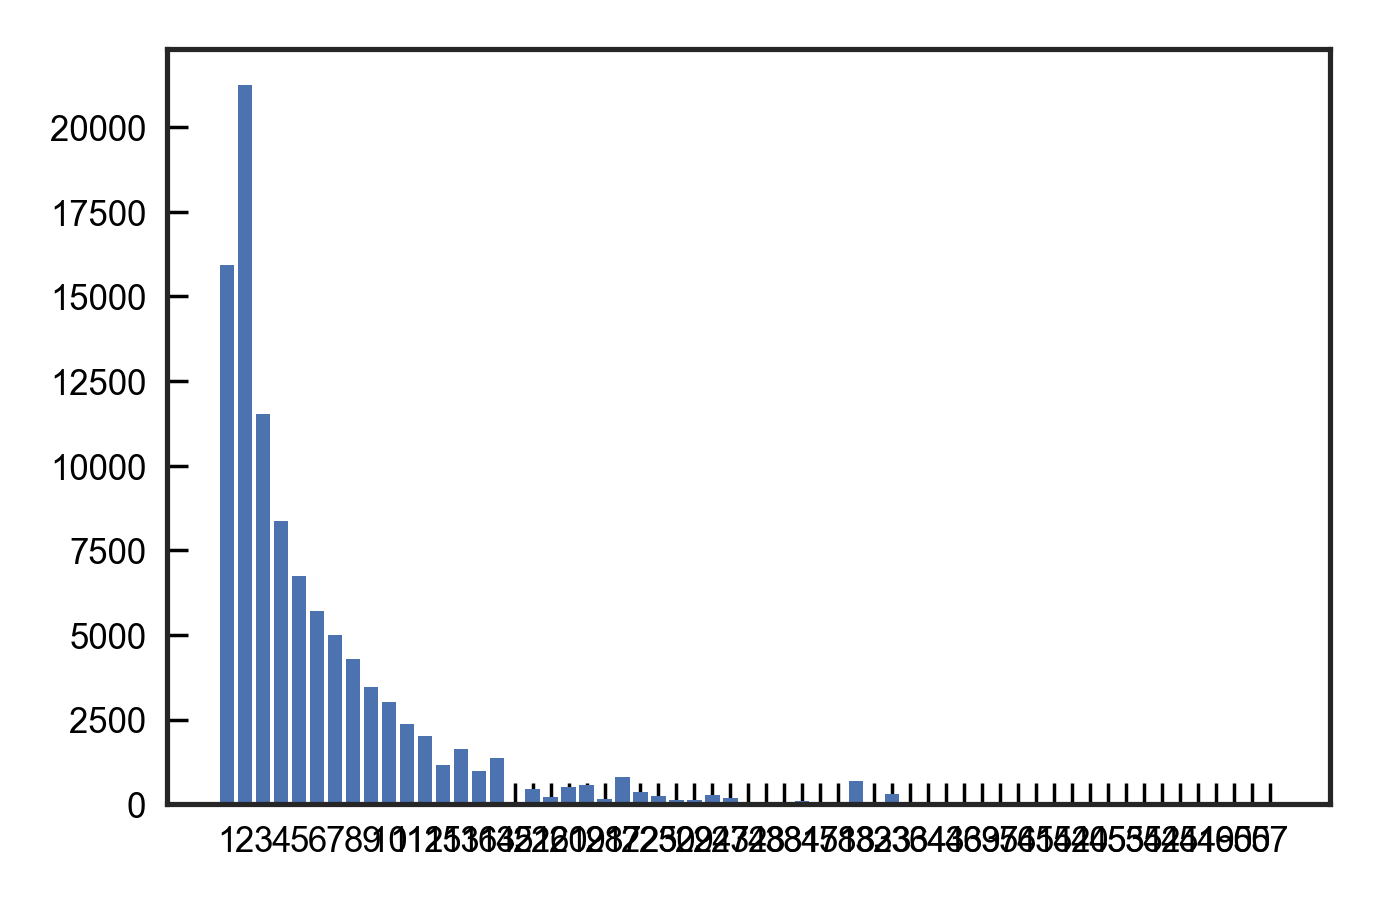

sequence sizes in different ranges of sequence count:
number of sequences with more than 1000 counts and their length: 
2    4
1    2
3    1
Name: seq_len, dtype: int64
number of sequences between 500 and 1000 counts and their length: 
3    5
2    2
1    1
Name: seq_len, dtype: int64
number of sequences with less than 500 counts and their length: 
8     3349
7     3287
9     3119
10    2859
6     2781
11    2294
12    1973
5     1799
13    1607
14    1364
15    1147
4      996
16     964
17     816
18     693
19     560
20     507
21     458
3      347
22     345
23     314
24     276
25     246
26     204
27     174
28     140
29     115
30     110
31      92
32      76
2       75
33      70
34      55
35      49
37      39
38      36
36      36
40      25
39      22
44      16
48      14
41      13
1       13
46      11
45       9
42       8
47       7
43       7
49       6
52       5
55       4
50       3
54       3
51       2
53       2
56       2
58       2
74       1
60       1
5

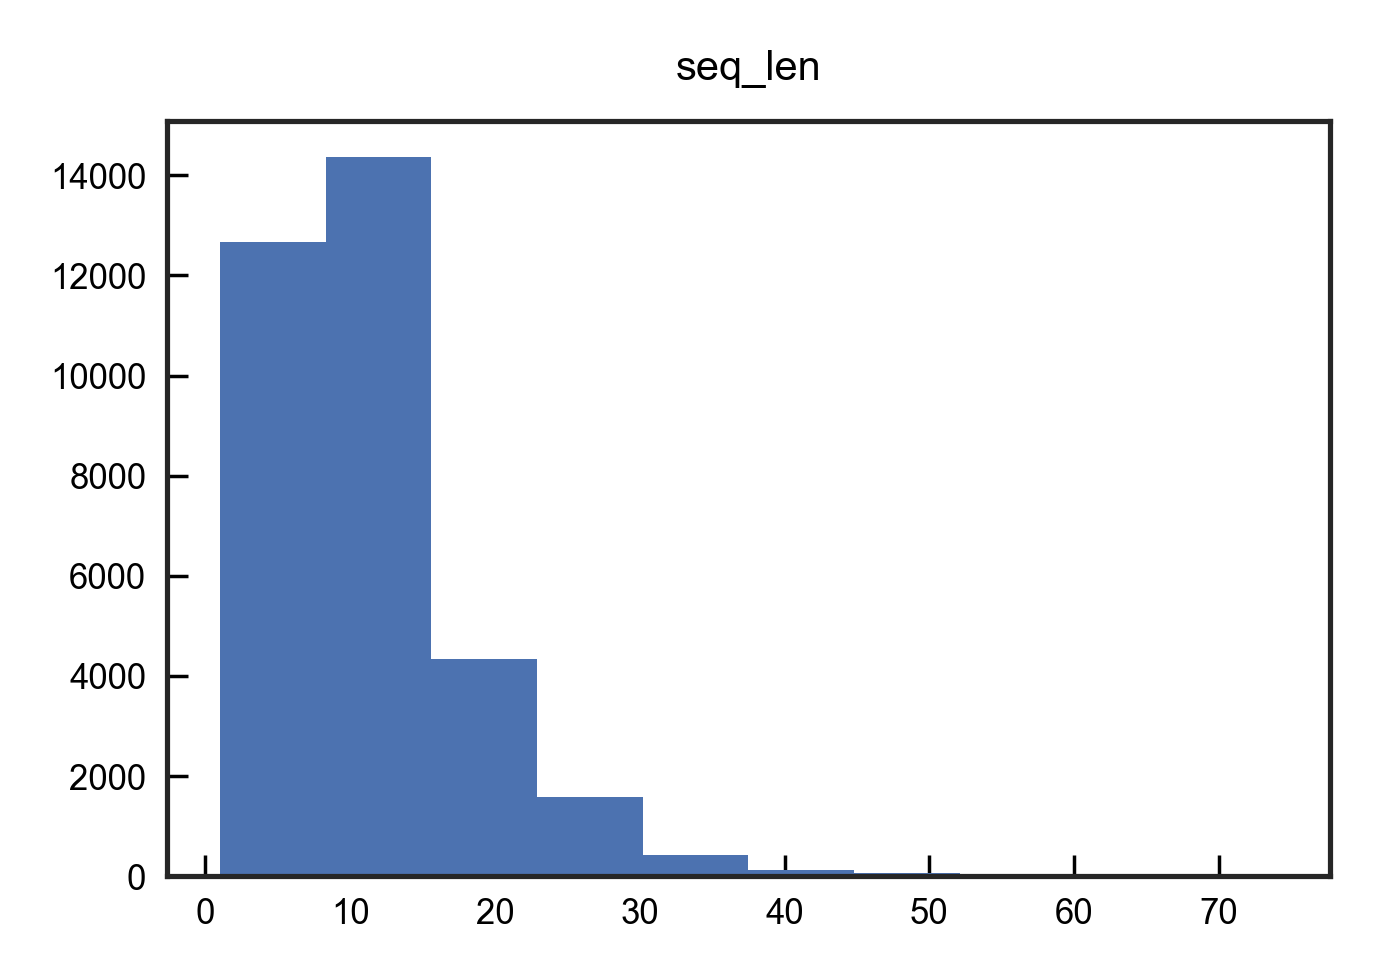

In [15]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import statistics
from more_itertools import locate
import operator
import matplotlib.pyplot as plt
import pickle

model_name = 'hmm_fb'

sorted_d, seq_sizes, seq_to_plot = sorted_seq_and_counts_hmm(hmm_seq)
plot_literal_count_per_seq(seq_sizes, model_name)
plot_len_grouped = plot_grouped_per_len_seq(sorted_d, seq_to_plot, model_name)

In [17]:
#save new results to file
with open('./src/generated_files/sorted_dict_'+ model_name+'.pkl', 'wb') as fp:
    pickle.dump(sorted_d, fp)

with open('./src/generated_files/seq_to_plot_'+ model_name+'.pkl', 'wb') as g:
    pickle.dump(seq_to_plot, g)

with open('./src/generated_files/'+model_name+'results.pkl', 'wb') as f:
    pickle.dump(hmm_seq, f)